# **IA353 - Redes Neurais: EFC1 - Questão 2**
## **Síntese de Modelos Não-lineares para Classificação de Padrões, mas Lineares nos Parâmetros Ajustáveis**

**Professor:** Fernando J. Von Zuben.

**Aluno(a)**: Guilherme Rosa

### **1. Importações**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rn

from tensorflow.keras.datasets import mnist

### **2. Definição de funções**

In [2]:
def categorical_to_onehot(vec):
    lin, col = vec.shape[0], 10
    Y = np.zeros((lin, col))

    for i in range(lin):
        Y[i, vec[i]] = 1
    
    return Y

In [3]:
def onehot_to_categorical(Y):
    vec = [np.argmax(Y[i]) for i in range(Y.shape[0])]
    vec = np.array(vec)
    
    return vec

In [4]:
def plot_digit_images(X, Y_categorical, titlesText, Nimgs=5):
    fig = plt.figure(figsize=(15,4))
    i = rn.randint(0, X.shape[0])

    for index, (image, label) in enumerate(zip(X[i:i+Nimgs], Y_categorical[i:i+Nimgs])):
        plt.subplot(1, Nimgs, index + 1)
        X_image = np.reshape(image, (28, 28))
        plt.imshow(X_image, cmap='gray')
        plt.axis('off')
        plt.title(titlesText + f'{label}\n', fontsize = 12)

In [5]:
def train_valid_split(X, y, random_state=42, valid_size=0.2):
    X_data, y_data = X.copy(), y.copy()
    train_len = int((1-valid_size)*X_data.shape[0])

    np.random.seed(random_state)
    np.random.shuffle([X_data, y_data])

    X_train, y = X_data[:train_len], y_data[:train_len]
    X_valid, yv = X_data[train_len:], y_data[train_len:]

    return X_train.copy(), y.copy(), X_valid.copy(), yv.copy()

In [6]:
def confusion_matrix(true_labels, predict_labels, num_classes):

    M = np.zeros((num_classes, num_classes))

    for k in range(true_labels.shape[0]):
        i, j = predict_labels[k], true_labels[k]
        M[i, j]+=1
    
    M = M.astype('int32')
    return M

### **3. Download da base de dados MNIST**

  - A base de dados MNIST é constituída pelos conjuntos de treinamento e teste. O primeiro conjunto possui 60.000 amostras de imagens de dígitos manuscritos, enquanto que o segundo conjunto possui 10.000 amostras.
  - As amostras da base MNIST, quando baixadas utilizando a API do Keras, apresentam as seguintes características:
    - As entradas estão no formato (28, 28, 1), isto é, uma matriz quadrada com cada pixel no intervalo [0, 255].
    - As saídas (rótulos) estão na representação categórica.
  - Após o download, os pixels das amostras de entrada passam por um processo de normalização, sendo divididos por 255, de modo que seus valores fiquem no intervalo [0, 1].
  - Nesta atividade, a normalização é necessária para que o mapeamento a ser aproximado pelo classificador linear seja mais suave, facilitando o processo de treinamento (i. e., a obtenção dos parâmetros do modelo).
  - Após a normalização: 
    - As amostras de entrada tem seus formatos alterados para (784,), pois a entrada do classificador linear é um vetor.
    - As saídas são convertidas para a codificação one-hot, pois a saída do classificador linear é um vetor em que cada elemento representa uma das classes do problema.

- Download e normalização dos dados:

In [7]:
(X_train, y), (X_test, yt) = mnist.load_data()

print('Valores máximo e mínimo antes da normalização:')
print(f'  X_train.max: {X_train.max()}')
print(f'  X_train.min: {X_train.min()}')

X_train, X_test = X_train/255., X_test/255.
print('Valores máximo e mínimo após da normalização:')
print(f'  X_train.max: {X_train.max()}')
print(f'  X_train.min: {X_train.min()}')

Valores máximo e mínimo antes da normalização:
  X_train.max: 255
  X_train.min: 0
Valores máximo e mínimo após da normalização:
  X_train.max: 1.0
  X_train.min: 0.0


- Dados com formato adequado para o treinamento:

In [8]:
X_train = np.reshape(X_train, (X_train.shape[0], -1))
y_train = categorical_to_onehot(y)
X_test = np.reshape(X_test, (X_test.shape[0], -1))
y_test = categorical_to_onehot(yt)

In [9]:
print('Dados de treinamento:')
print(f'  Dimensão de X_train: {X_train.shape}')
print(f'  Dimensão de y_train: {y_train.shape}')
print('------------------------------------')
print('Dados de teste:')
print(f'  Dimensão de X_test: {X_test.shape}')
print(f'  Dimensão de y_test: {y_test.shape}')

Dados de treinamento:
  Dimensão de X_train: (60000, 784)
  Dimensão de y_train: (60000, 10)
------------------------------------
Dados de teste:
  Dimensão de X_test: (10000, 784)
  Dimensão de y_test: (10000, 10)


- Exemplo de amostras de treinamento e teste:

In [10]:
n1 = rn.randint(0, y_train.shape[0])

print('Exemplo do conjunto de treinamento:')
print(f'Saída na representação categórica: {y_train[n1]}')
print(f'Saída na representação one-hot: {y[n1]}')

print('--------------------------------------------------------------')
n1 = rn.randint(0, y_test.shape[0])

print('Exemplo do conjunto de teste:')
print(f'Saída na representação categórica: {y_test[n1]}')
print(f'Saída na representação one-hot: {yt[n1]}')

Exemplo do conjunto de treinamento:
Saída na representação categórica: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Saída na representação one-hot: 9
--------------------------------------------------------------
Exemplo do conjunto de teste:
Saída na representação categórica: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Saída na representação one-hot: 2


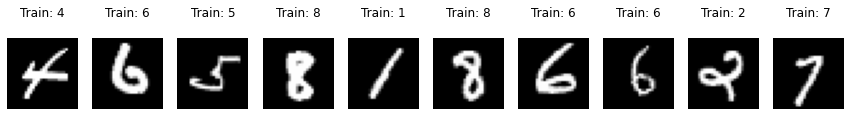

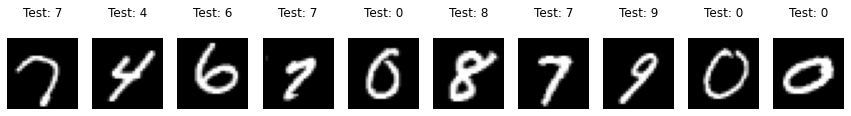

In [11]:
plot_digit_images(X_train, y, titlesText='Train: ', Nimgs=10);
plot_digit_images(X_train, y, titlesText='Test: ', Nimgs=10);

### **4. Separação das amostras de treinamento em amostras de treinamento e validação**

- Com relação aos dados, a última etapa de pré-processamento consiste na separação das amostras de treinamento nos conjuntos de treinamento e validação.
- A técnica utilizada na atividade é chamada holdout, em que uma parcela das amostras de treinamento são utilizadas apenas para validação do modelo.
- O conjunto de treinamento é formado por 80% das 60.000 amostras, que são utilizadas diretamente para a obtenção dos parâmetros do classificador.
- O conjunto de validação é formado pelos restantes 20% das amostras que são utilizadas para validar ou verificar o desempenho do classificador obtido junto aos dados de treinamento.
- A ideia da validação cruzada consiste em analisar o erro do modelo junto aos dados de validação de modo que, quanto menor o erro de validação, maior a capacidade de generalização do modelo.

In [12]:
X_train, y, X_valid, yv = train_valid_split(X_train, y)
y_train = categorical_to_onehot(y)
y_valid = categorical_to_onehot(yv)

In [13]:
print('Dados de treinamento:')
print(f'  Dimensão da matriz X_train: {X_train.shape}')
print(f'  Dimensão da matriz Y_train: {y_train.shape}')
print('--------------------------------------')
print('Dados de validação:')
print(f'  Dimensão da matriz X_valid: {X_valid.shape}')
print(f'  Dimensão da matriz Y_valid: {y_valid.shape}')

Dados de treinamento:
  Dimensão da matriz X_train: (48000, 784)
  Dimensão da matriz Y_train: (48000, 10)
--------------------------------------
Dados de validação:
  Dimensão da matriz X_valid: (12000, 784)
  Dimensão da matriz Y_valid: (12000, 10)


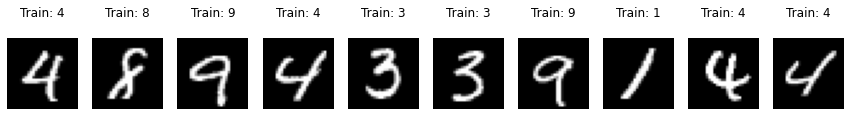

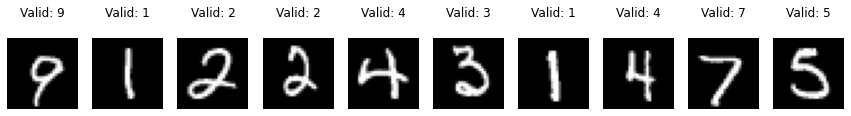

In [14]:
plot_digit_images(X_train, y, titlesText='Train: ', Nimgs=10);
plot_digit_images(X_valid, yv, titlesText='Valid: ', Nimgs=10);

### **5. Classificador linear, Extreme Learning Machine (ELM) e métricas de treinamento**

In [15]:
class LinearClassifier():
    
    def __init__(self, X_train, Y_train):
        self.Xt = X_train
        self.Yt = Y_train
        self.Nt, self.Kt = None, X_train.shape[1]
        self.W, self.Phi_t, self.Im = None, None, None
    
    def fit(self, coef_reg):
        [self.Nt, self.K] = self.Xt.shape
        self.Phi_t = np.insert(self.Xt, 0, np.ones([1, self.Nt]), axis=1)
        self.Im = np.insert(np.insert(np.eye(self.K), 0, np.zeros([1, self.K]), axis=0), 0, np.zeros([1, self.K+1]), axis=1)
        self.W = np.linalg.inv(np.transpose(self.Phi_t).dot(self.Phi_t) + coef_reg*self.Im).dot(np.transpose(self.Phi_t).dot(self.Yt))

    def evaluate(self, X_valid, Y_valid):
        Phi_v = np.insert(X_valid, 0, np.ones([1, X_valid.shape[0]]), axis=1)
        Y_valid = Phi_v.dot(self.W)
        Y_valid_onehot = LinearClassifier.to_onehot(self, Y_valid)
        return Y_valid, Y_valid_onehot

    def predict(self, X_pred, Y_pred):
        Phi_p = np.insert(X_pred, 0, np.ones([1, X_pred.shape[0]]), axis=1)
        Y_pred = Phi_p.dot(self.W)
        Y_pred_onehot = LinearClassifier.to_onehot(self, Y_pred)
        return Y_pred, Y_pred_onehot
        
    def to_onehot(self, Y_est):
        Yest_onehot = Y_est.copy()
        for i in range(0, Yest_onehot.shape[0]):   
            np.place(Yest_onehot[i], Yest_onehot[i] < np.max(Yest_onehot[i]), 0)
            np.place(Yest_onehot[i], Yest_onehot[i] == np.max(Yest_onehot[i]), 1)
        return Yest_onehot

In [16]:
class ELM(LinearClassifier):
    
    def __init__(self, X_train, Y_train, m, dist, param1, param2, activ_func, seed=0):
        super().__init__(X_train, Y_train)
        self.m = m
        self.V = None
        self.dist = dist
        self.param1 = param1
        self.param2 = param2
        self.activ_func = activ_func
        self.seed = seed
        self.Xt = ELM.nonlinearprocessing(self, X_train)

    def param_intermediate_layer(self, X):
        np.random.seed(self.seed)

        if self.dist == 'normal':
            self.V = np.random.normal(self.param1, self.param2, (self.Kt, self.m))
            X = X.dot(self.V)
        elif self.dist == 'uniform':
            self.V = np.random.uniform(self.param1, self.param2, (self.Kt, self.m))
            X = X.dot(self.V)
        return X
            
    def activation_function(self, X):
        if self.activ_func == 'tanh':
            X = np.tanh(X)
        elif self.activ_func == 'relu':
            np.place(X, X <= 0, 0)
        return X
    
    def nonlinearprocessing(self, X):
        X = ELM.activation_function(self, ELM.param_intermediate_layer(self, X))
        return X
    
    def evaluate(self, X_valid, Y_valid):
        X_valid = ELM.nonlinearprocessing(self, X_valid)
        Phi_v = np.insert(X_valid, 0, np.ones([1, X_valid.shape[0]]), axis=1)
        Y_valid = Phi_v.dot(self.W)
        Y_valid_onehot = LinearClassifier.to_onehot(self, Y_valid)
        return Y_valid, Y_valid_onehot

    def predict(self, X_pred, Y_pred):
        X_pred = ELM.nonlinearprocessing(self, X_pred)
        Phi_p = np.insert(X_pred, 0, np.ones([1, X_pred.shape[0]]), axis=1)
        Y_pred = Phi_p.dot(self.W)
        Y_pred_onehot = LinearClassifier.to_onehot(self, Y_pred)
        return Y_pred, Y_pred_onehot

In [17]:
class Metrics():
    
    def __init__(self, Y, Yest, Yest_onehot):
        self.Y = Y
        self.Yest = Yest
        self.Yest_onehot = Yest_onehot    
        self.MSE = None
        self.CE = None
    
    def meansquared_error(self):
        e = (self.Y - self.Yest)**2
        self.MSE = np.sum(np.sum(e, axis=1), axis=0) # / (N*L), onde [N, L] = self.Yval.shape
        return self.MSE
    
    def classification_error(self):
        matches = []
        
        for i in range(0, self.Y.shape[0]):
            matches.append(np.array_equal(self.Y[i], self.Yest_onehot[i]))
        
        score = matches.count(True)
        err = self.Y.shape[0] - score
        self.CE = err/(err + score)
        return self.CE

### **6. Busca inicial pelos melhores coeficientes de regularização**

##### **6.1. Especificações (conforme o enunciado) e construção da ELM**
- 500 neurônios na camada intermediária (*M = 500*).
- Os pesos sinápticos dos neurônios da camada intermediária são gerados aleatoriamente de acordo com uma distribuição gaussiana de média zero e desvio padrão igual a 0.2.
- Os pesos são gerados uma única vez durante a instanciação na classe ELM, de modo que a mesma matriz de pesos da camada intermediária é utilizada em todas as etapas da resolução.
- A escolha da função de ativação dos neurônios foi deixada em aberto. Nessa etapa, foi escolhido a função tangente hiperbólica.  

In [18]:
classifier = ELM(X_train, y_train, m=500, dist='normal', param1=0, param2=0.2, activ_func='tanh', seed=1)

coefs_best_MSE = []
coefs_best_CE = []

##### **6.2. Etapa de treinamento e validação - Busca inicial pelos melhores coeficientes de regularização:**
- Inicialmente será feito uma busca pelos coeficientes de regularização $\lambda$, entre os valores abaixo, que levem aos menores valores de erro quadrático médio e taxa de erro de classificação. 
$$ A = \{2^{-20},\; 2^{-19}, \ldots,\; 2^{0},\; \ldots, \; 2^{+19},\ldots,\; 2^{+20} \}$$

- Treinamento e validação dos classificadores:

In [ ]:
coefs = [2**n for n in range(-20, 21, 1)]

ms_errors = np.array([]) # Armazena o erro quadrático médio para cada coeficiente de regularização
ce_errors = np.array([]) # Armazena o erro de classificação para cada coeficiente de regularização

for coef in coefs:
    classifier.fit(coef) # treinamento
    Y_est_valid, Y_est_valid_onehot = classifier.evaluate(X_valid, y_valid) # validação
    
    desempenho = Metrics(y_valid, Y_est_valid, Y_est_valid_onehot)
    
    ms_errors = np.append(ms_errors, desempenho.meansquared_error())
    ce_errors = np.append(ce_errors, desempenho.classification_error())
    print('MSE: %.4f -- Taxa de Erro: %.4f -- Coeficiente: %.5f' % (ms_errors[-1], ce_errors[-1], coef))

coefs_best_MSE.append(coefs[np.argmin(ms_errors)])  # melhor coef. de regularização considerando o erro quadrático médio
coefs_best_CE.append(coefs[np.argmin(ce_errors)])  # melhor coef. de regularização considerando o erro de classificação

- Melhores coeficientes de regularização obtidos:

In [20]:
ms_errors1 = ms_errors.copy()
ce_errors1 = ce_errors.copy()

print(f'Coeficiente de regularização para o menor erro quadrático médio: {coefs_best_MSE}')
print(f'Coeficiente de regularização para o menor erro de classificação: {coefs_best_CE}')

Coeficiente de regularização para o menor erro quadrático médio: [256]
Coeficiente de regularização para o menor erro de classificação: [8]


- Gráfico semilog do desempenho dos classificadores junto aos dados de validação considerando o erro quadrático médio:

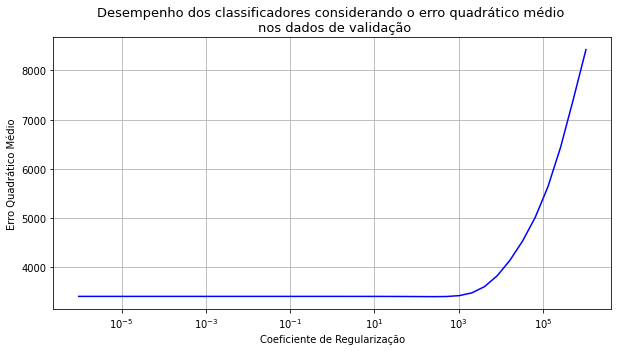

In [21]:
plt.figure(figsize=(10,5))

plt.semilogx(coefs, ms_errors1, color='b')
plt.grid(True, which="both")
plt.xticks()
plt.title('Desempenho dos classificadores considerando o erro quadrático médio \n nos dados de validação', fontsize=13)
plt.xlabel('Coeficiente de Regularização')
plt.ylabel('Erro Quadrático Médio')
plt.show()

- Gráfico semilog do desempenho dos classificadores junto aos dados de validação consideranda taxa de erro de classificação:

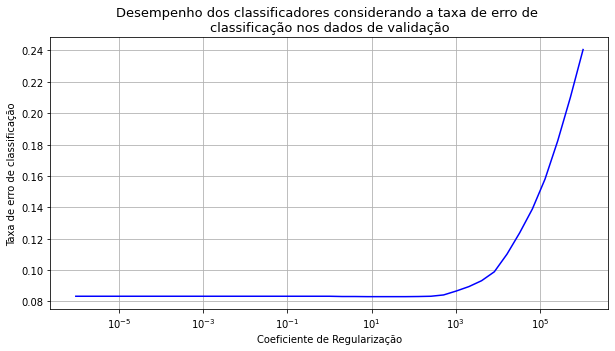

In [22]:
plt.figure(figsize=(10,5))
plt.semilogx(coefs, ce_errors1, color='b')
plt.grid(True, which="both")
plt.title('Desempenho dos classificadores considerando a taxa de erro de \nclassificação nos dados de validação', fontsize=13)
plt.xlabel('Coeficiente de Regularização')
plt.ylabel('Taxa de erro de classificação')
plt.show()

### **7. Busca refinada pelos melhores coeficientes de regularização**

##### **7.1. Busca refinada pelo melhor coeficiente de regularização considerando o erro quadrático médio junto aos dados de validação**


- Busca refinada I: Treinamento e validação do modelo para 200 valores de $\lambda$ no intervalo $[246, 266]$ linearmente espaçados:


In [ ]:
print(f'coefs_best_MSE[-1] = {coefs_best_MSE[-1]}')

coefs = np.linspace(coefs_best_MSE[-1]-10, coefs_best_MSE[-1]+10, num=200)
ms_errors = np.array([]) # Armazena os valores de erros quadráticos médios

for coef in coefs:
    classifier.fit(coef) # treinamento
    Y_est_valid, Y_est_valid_onehot = classifier.evaluate(X_valid, y_valid) # validação
    
    desempenho = Metrics(y_valid, Y_est_valid, Y_est_valid_onehot)
    ms_errors = np.append(ms_errors, desempenho.meansquared_error())
    print('MSE: %.4f -- Coeficiente: %4.4f' % (ms_errors[-1], coef))
    
coefs_best_MSE.append(coefs[np.argmin(ms_errors)])

- Busca refinada II: Treinamento e validação do modelo para 200 valores de $\lambda$ no intervalo $[266, 286]$ linearmente espaçados:

In [ ]:
print(f'coefs_best_MSE[-1] = {coefs_best_MSE[-1]}')

coefs = np.linspace(coefs_best_MSE[-1], coefs_best_MSE[-1]+20, num=200)
ms_errors = np.array([]) # Armazena os valores de erros quadráticos médios

for coef in coefs:
    classifier.fit(coef) # treinamento
    Y_est_valid, Y_est_valid_onehot = classifier.evaluate(X_valid, y_valid) # validação
    
    desempenho = Metrics(y_valid, Y_est_valid, Y_est_valid_onehot)
    ms_errors = np.append(ms_errors, desempenho.meansquared_error())
    print('MSE: %.4f -- Coeficiente: %4.4f' % (ms_errors[-1], coef))
    
coefs_best_MSE.append(coefs[np.argmin(ms_errors)])

- Melhor coeficiente de regularização obtido:

In [26]:
ms_errors2 = ms_errors.copy()

print(f'Coeficiente de regularização para o menor erro quadrático médio: {coefs_best_MSE[-1]}')

Coeficiente de regularização para o menor erro quadrático médio: 272.4321608040201


- Gráfico semilog do desempenho dos classificadores junto aos dados de validação considerando o erro quadrático médio:

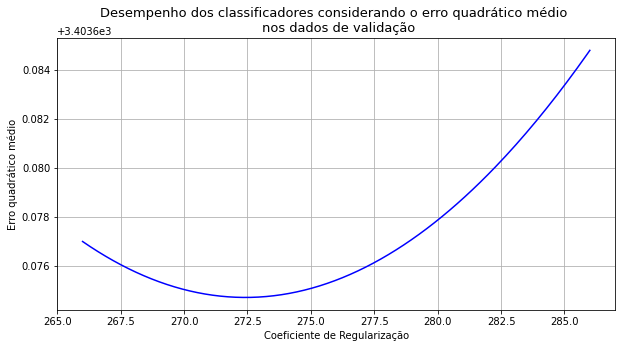

In [27]:
plt.figure(figsize=(10,5))
plt.plot(coefs, ms_errors2, color='b')
plt.grid(True, which="both")
plt.title('Desempenho dos classificadores considerando o erro quadrático médio \n nos dados de validação', fontsize=13)
plt.xlabel('Coeficiente de Regularização')
plt.ylabel('Erro quadrático médio')
plt.show()

##### **7.2. Busca refinada pelo melhor coeficiente de regularização considerando o erro de classificação**


- Busca refinada I: Treinamento e validação do modelo para 100 valores de $\lambda$ no intervalo $[3, 13]$ espaçados linearmente


In [ ]:
print(f'coefs_best_CE[-1] = {coefs_best_CE[-1]}')
coefs = np.linspace(coefs_best_CE[-1]-5, coefs_best_CE[-1]+5, num=100)

ce_errors = [] # Armazena os valores de erros de classificação

for coef in coefs:
    classifier.fit(coef) # treinamento
    Y_est_valid, Y_est_valid_onehot = classifier.evaluate(X_valid, y_valid) # validação
    
    desempenho = Metrics(y_valid, Y_est_valid, Y_est_valid_onehot)
    ce_errors.append(desempenho.classification_error())
    print('Taxa de Erro: %.4f -- Coeficiente: %.4f' % (ce_errors[-1], coef))

coefs_best_CE.append(coefs[np.argmin(ce_errors)])

- Busca refinada II: Treinamento e validação do modelo para 100 valores de $\lambda$ no intervalo $[5.24, 15.24]$ espaçados linearmente 

In [ ]:
print(f'coefs_best_CE[-1] = {coefs_best_CE[-1]}')
coefs = np.linspace(coefs_best_CE[-1]-2, coefs_best_CE[-1]+8, num=100)

ce_errors = [] # Armazena os valores de erros de classificação

for coef in coefs:
    classifier.fit(coef) # treinamento
    Y_est_valid, Y_est_valid_onehot = classifier.evaluate(X_valid, y_valid) # validação
    
    desempenho = Metrics(y_valid, Y_est_valid, Y_est_valid_onehot)
    ce_errors.append(desempenho.classification_error())
    print('Taxa de Erro: %.4f -- Coeficiente: %.4f' % (ce_errors[-1], coef))

coefs_best_CE.append(coefs[np.argmin(ce_errors)])

- Melhor coeficiente de regularização obtido:

In [30]:
ce_errors2 = ce_errors.copy()

print(f'Coeficiente de regularização para o menor erro de classificação: {coefs_best_CE[-1]}')

Coeficiente de regularização para o menor erro de classificação: 7.161616161616161


- Gráfico semilog do desempenho dos classificadores junto aos dados de validação consideranda taxa de erro de classificação:

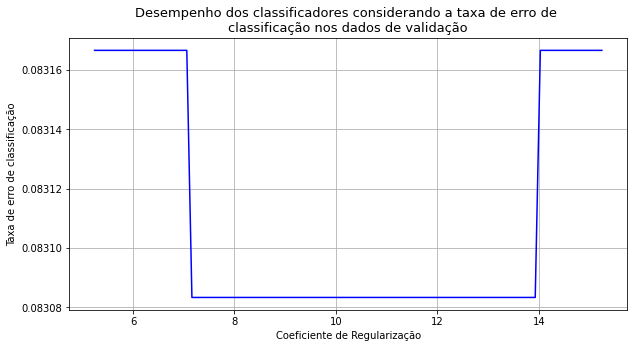

In [31]:
plt.figure(figsize=(10,5))
plt.plot(coefs, ce_errors2, color='b')
plt.grid(True, which="both")
plt.title('Desempenho dos classificadores considerando a taxa de erro de \nclassificação nos dados de validação', fontsize=13)
plt.xlabel('Coeficiente de Regularização')
plt.ylabel('Taxa de erro de classificação')
plt.show()

### **8. Etapa de teste do melhor classificador linear obtido após o treinamento**


##### **8.1. Treinamento do modelo com todas as 60.000 amostras de treinamento:**

In [32]:
best_coef = coefs_best_CE[-1]

bestClassifier = ELM(X_train, y_train, m=500, dist='normal', param1=0, param2=0.2, activ_func='tanh', seed=1)
bestClassifier.fit(best_coef) #treinamento

##### **8.2. Teste do modelo com as 10.000 amostras de teste:**

In [33]:
Y_est_test, Y_est_test_onehot = bestClassifier.predict(X_test, y_test)

desempenho = Metrics(y_test, Y_est_test, Y_est_test_onehot)

ms_error = desempenho.meansquared_error()
ce_error = desempenho.classification_error()

print(f'Erro quadrático médio (MSE): {ms_error}')
print(f'Taxa de erro de classificação: {ce_error}')

Erro quadrático médio (MSE): 2845.744518408896
Taxa de erro de classificação: 0.0825


##### **8.3. Matriz de Confusão**

- Abaixo está apresentada a matriz de confusão da melhor ELM obtido durante o treinamento.
- A ELM:
  - Assim como o classificador linear, ela teve melhor desempenho para classificar as amostras da classe 1 e pior desempenho para classificar as amostras da classe 5 (Análise feita na diagonal principal).
  - Classificou incorretamente um maior número de amostras da classe 2 como 8, da classe 4 como 9, da classe 5 como 3 e da classe 9 como 4 (Análise feita nas colunas da matriz de confusão).
  - Apresenta uma taxa de erro de classificação menor que a do classificador linear.

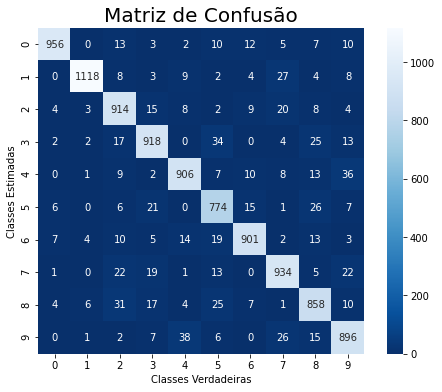

In [34]:
Y_est_test_categorical = onehot_to_categorical(Y_est_test_onehot)

index = [i for i in "0123456789"]
plt.figure(figsize=(8, 6))

sns.heatmap(confusion_matrix(yt, Y_est_test_categorical, 10), annot=True, annot_kws={'size': 10}, square=True, fmt='d', xticklabels=index, yticklabels=index, cmap='Blues_r');
plt.title('Matriz de Confusão', fontsize=20);
plt.xlabel('Classes Verdadeiras');
plt.ylabel('Classes Estimadas');

##### **8.4. Exemplos de dígitos classificados incorretamente**
 

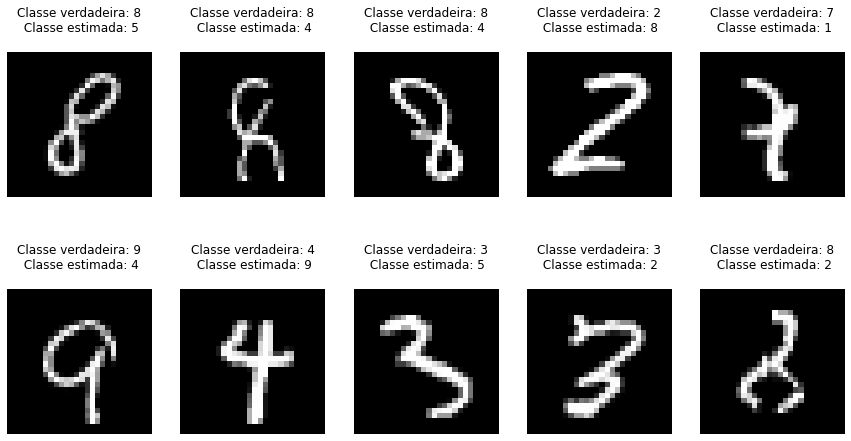

In [35]:
estErr = np.array([1 if imagem != 0 else 0 for imagem in yt - Y_est_test_categorical])
indices = list(np.where(estErr == 1)[0])

plt.figure(figsize=(15,8))

N = 50

for index_subplot, index_amostra in enumerate(indices[N:N+10]):
    plt.subplot(2, 5, index_subplot+1)
    X_image = np.reshape(X_test[index_amostra], (28, 28))
    plt.imshow(X_image, cmap='gray')
    plt.axis('off')
    plt.title(f'Classe verdadeira: {yt[index_amostra]}\n Classe estimada: {Y_est_test_categorical[index_amostra]}\n')

### **9. Análise de mudanças nas especificações da ELM**

- Mudanças no(a):
  - Gerador pseudo-aleatório
  - Função distribuição de probabilidade
  - Número de neurônios da camada intermediária
  - Função de ativação dos neurônios da camada intermediária

|Modelo|Número de neurônios|Semente do gerador|   PDF   |Função de Ativação|
|------|-------------------|------------------|---------|------------------|
|1     |500                |10                |Normal   |tanh              |
|2     |500                |1                 |Uniforme |tanh              |
|3     |500                |1                 |Normal   |relu              |
|4     |1000               |1                 |Normal   |tanh              |
|5     |1000               |1                 |Normal   |relu              |

In [36]:
hyperparams = []

hyperparams.append({'m': 500, 'seed': 10, 'dist': 'normal', 'param1': 0, 'param2': 0.2, 'activ_func': 'tanh'})
hyperparams.append({'m': 500, 'seed': 1, 'dist': 'uniform', 'param1': -0.5, 'param2': 0.5, 'activ_func': 'tanh'})
hyperparams.append({'m': 500, 'seed': 1, 'dist': 'normal', 'param1': 0, 'param2': 0.2, 'activ_func': 'relu'})
hyperparams.append({'m': 1000, 'seed': 1, 'dist': 'normal', 'param1': 0, 'param2': 0.2, 'activ_func': 'tanh'})
hyperparams.append({'m': 1000, 'seed': 1, 'dist': 'normal', 'param1': 0, 'param2': 0.2, 'activ_func': 'relu'})

- Treinamento e validação:

In [ ]:
classifiers = []

ELM(X_train, y_train, m=500, dist='normal', param1=0, param2=0.2, activ_func='tanh')
for i in range(0, 5):
    classifiers.append(ELM(X_train, y_train, 
                           m=hyperparams[i]['m'], 
                           dist=hyperparams[i]['dist'], 
                           param1=hyperparams[i]['param1'], 
                           param2=hyperparams[i]['param2'], 
                           activ_func=hyperparams[i]['activ_func'], 
                           seed=hyperparams[i]['seed']))
  
coefs = [2**n for n in range(-20, 21, 1)]
coefs_best_MSE = []
coefs_best_CE = []
best_MSE = []
best_CE = []

for i in range(0, 5):
    ms_errors = np.array([]) # Armazena os valores de erros quadráticos médios
    ce_errors = np.array([]) # Armazena os valores de erros de classificação

    print(f'Treino do classificador {i}:')

    for coef in coefs:
        classifiers[i].fit(coef) # treinamento
        Y_est_valid, Y_est_valid_onehot = classifiers[i].evaluate(X_valid, y_valid) # validação
        
        desempenho = Metrics(y_valid, Y_est_valid, Y_est_valid_onehot)
        
        ms_errors = np.append(ms_errors, desempenho.meansquared_error())
        ce_errors = np.append(ce_errors, desempenho.classification_error())

        print('MSE: %.4f -- Taxa de Erro: %.4f -- Coeficiente: %.6f' % (ms_errors[-1], ce_errors[-1], coef))

    coefs_best_MSE.append(coefs[np.argmin(ms_errors)])  # melhor coef. de regularização considerando o erro quadrático médio
    coefs_best_CE.append(coefs[np.argmin(ce_errors)])  # melhor coef. de regularização considerando o erro de classificação
    best_MSE.append(np.min(ms_errors))
    best_CE.append(np.min(ce_errors))

- Resultados:

In [38]:
for i in range(0, 5):
    print('Classificador %d -- MSE: %.4f -- Taxa de Erro: %.4f -- Coef. MSE: %d -- Coef. CE: %d' % (i+1,  best_MSE[i], best_CE[i], coefs_best_MSE[i], coefs_best_CE[i]))

Classificador 1 -- MSE: 3362.2074 -- Taxa de Erro: 0.0838 -- Coef. MSE: 256 -- Coef. CE: 0
Classificador 2 -- MSE: 3479.6120 -- Taxa de Erro: 0.0874 -- Coef. MSE: 256 -- Coef. CE: 128
Classificador 3 -- MSE: 3318.9365 -- Taxa de Erro: 0.0788 -- Coef. MSE: 128 -- Coef. CE: 0
Classificador 4 -- MSE: 2750.5272 -- Taxa de Erro: 0.0628 -- Coef. MSE: 256 -- Coef. CE: 32
Classificador 5 -- MSE: 2562.6287 -- Taxa de Erro: 0.0541 -- Coef. MSE: 256 -- Coef. CE: 64


### **10. Perguntas conceituais do enunciado da questão**

##### **10.1. Apresente e compare o erro quadrático médio, a taxa de erro de classificação e os dois melhores coeficientes de regularização obtidos para o classificador linear e para a ELM.**

|Modelo|MSE Error|CE Error|Melhor $\lambda_{MSE}$|Melhor $\lambda_{CE}$|
|------|---------|--------|----------------------|---------------------|
|Linear|3906.64  |0.1346  |51.62                 |1166.74              |
|ELM   |2845.74  |0.0825  |272.43                |7.16                 |

- A ELM, devido ao processamento não-linear dos atributos pela camada intermediária, promoveu um ganho de desempenho quando comparado ao classificador linear. De fato, o erro quadrático médio e a taxa de erro de classificação são menores para a máquina obtida na Questão 2.

- Com relação aos coeficientes de regularização, nota-se que ocorreu um aumento quando considerado o erro quadrático médio e uma redução quando considerada a taxa de erro de classificação.

- Isso significa que, no caso do erro quadrático médio, a camada de saída da melhor ELM possui uma flexibilidade muito maior que o classificador linear. Por outro lado, no caso da taxa de erro de classificação, o mapeamento não-linear da camada intermediária diminuiu a necessidade de regularização dos pesos da camada de saída.

##### **10.2. Seguindo a sugestão de empregar 500 unidades na camada intermediária da rede neural, apresente argumentos para sustentar o ganho de desempenho verificado e uma execução em menor tempo computacional, quando comparado com o classificador linear da Q1.**

- O ganho de desempenho da ELM em comparação ao classificador linear deve-se à presença da camada intermediária de neurônios que realiza transformações não-lineares nos atributos das amostras de entrada, ou seja, cada neurônio da camada intermediária é responsável por criar um mapeamento não-linear que será posteriormente combinado pelos neurônios da camada de saída para estimar a classe das amostras. Outro fator que explica o ganho de desempenho da ELM é o aumento da flexibilidade do modelo.

- A diminuição no tempo de execução da ELM em comparação ao classificador linear deve-se à redução nas dimensões das matrizes envolvidas na resolução do problema de quadrados mínimos regularizado. No caso do classificador linear, o problema envolve uma matriz de parâmetros de dimensão 785x10 e uma matriz de amostras de entrada de dimensão Nx785 (incluindo o termo de bias). No caso da ELM, o problema de otimização envolve uma matriz de amostras “transformadas” de dimensão Nx501 (incluindo o termo de bias) e uma matriz de parâmetros de dimensão 501x10. Como a solução de quadrados mínimos regularizado envolve inversão de matrizes, a redução das dimensões leva a um menor esforço computacional e, consequentemente, a um menor tempo de execução.


##### **10.3. O que você espera que ocorra com o coeficiente de regularização caso os neurônios da camada intermediária sejam inicializados com pesos sinápticos distintos a cada execução?**

- Se os pesos dos neurônios da camada intermediária forem inicializados com valores distintos a cada execução, é esperado que o coeficiente de regularização associado aos menores erros (erro quadrático médio e de classificação) sejam diferentes para cada inicialização, pois inicializações diferentes resultam em problemas de otimização diferentes.


##### **10.4. Promova algum tipo de alteração nas especificações da ELM e/ou de seu treinamento de modo a produzir resultados superiores àqueles conquistados ao se seguir o roteiro desta questão.**

|Modelo|Número de neurônios|Função de Ativação|MSE Error|CE Error|
|------|-------------------|------------------|---------|--------|
|ELM   |500                |tanh              |2845.74  |0.0825  |
|ELM 5 |1000               |relu              |2562.63  |0.0541  |

- A ELM 5 da Seção 9, que contém 1000 neurônios na camada intermediária com funções de ativação ReLU apresenta um desempenho superior à ELM com arquitetura proposta no enunciado.  